In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from import_dmr import *
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [4]:
from collections import defaultdict

facilities_list = pd.read_csv('filtered_full_facilities_listV2.csv')
print(facilities_list.columns.to_list())
facilites_columns_to_keep = ['REGION',
 'FACILITY.ID',
 'LATITUDE.DECIMAL.DEGREES', 
 'LONGITUDE.DECIMAL.DEGREES',
 'FACILITY.NAME',
 'PLACE.TYPE',
 'PLACE.SUBTYPE',
 'FACILITY.TYPE',
 'CAL.WATERSHED.NAME',
 'NPDES...CA.']
facilities_list = facilities_list[facilites_columns_to_keep]


limits_2023 = read_limits(2023)
# for each row, lookup the CATEGORY for the row's POLLUTANT_CODE from ref_parameter.csv and add it to a new column in list_2023
ref_parameter = pd.read_csv('REF_Parameter.csv')
pollutant_category_map = dict(zip(ref_parameter['PARAMETER_CODE'], ref_parameter['CATEGORY']))
limits_2023['CATEGORY'] = limits_2023['PARAMETER_CODE'].map(pollutant_category_map)
limits_2023.head()

# categories = ['Pathogens', 'Metals', 
#               'Nutrients', 'Sediment', 
#               'Toxic Organics', 'Other Cause', 
#               'SALINITY/TOTAL DISSOLVED SOLIDS/CHLORIDES/SULFATES', 
#               'Pesticides', 
#               'Total Toxics', 'Toxic Inorganics', 'Trash']

categories = ['Pathogens', 'Metals', 'Nutrients']

# from 303d folder import 2018-303d and 2023-303d.csv 
impaired_303d_2018 = pd.read_csv('303d/2018-303d.csv', skiprows=2)
impaired_303d_2024 = pd.read_csv('303d/2024-303d.csv', skiprows=1)

columns_to_keep = ['Water Body CALWNUMS', 'Pollutant', 'Pollutant Category', 'Decision Status', 'TMDL Requirement Status',
       'Sources', 'Expected TMDL Completion Date', 'Expected Attainment Date']
impaired_303d_2018 = impaired_303d_2018[columns_to_keep]
impaired_303d_2024 = impaired_303d_2024[columns_to_keep]

# drop na rows for water body calwnums
impaired_303d_2018 = impaired_303d_2018.dropna(subset=['Water Body CALWNUMS'])
impaired_303d_2024 = impaired_303d_2024.dropna(subset=['Water Body CALWNUMS'])


# Create a dictionary to store the newly impaired water bodies for each category
newly_impaired_water_bodies = defaultdict(set)
for category in categories:
    nutrient_impaired_set_2018 = set(impaired_303d_2018.loc[impaired_303d_2018['Pollutant Category'] == category, 'Water Body CALWNUMS'])
    nutrient_impaired_set_2024 = set(impaired_303d_2024.loc[impaired_303d_2024['Pollutant Category'] == category, 'Water Body CALWNUMS'])
    newly_impaired_water_bodies[category] = nutrient_impaired_set_2024 - nutrient_impaired_set_2018

def contains_impaired_water_body(watershed_name, impaired_water_bodies):
    if pd.isna(watershed_name):
        return False
    return any(water_body in watershed_name for water_body in impaired_water_bodies)

for category in categories:
    facilities_list[f'DISCHARGES_TO_NEWLY_{category}_IMPAIRED_BODY'] = facilities_list['CAL.WATERSHED.NAME'].apply(contains_impaired_water_body, impaired_water_bodies=newly_impaired_water_bodies[category])
    facilities_list[f'DISCHARGES_TO_{category}_IMPAIRED_BODY'] = facilities_list['CAL.WATERSHED.NAME'].apply(contains_impaired_water_body, impaired_water_bodies=newly_impaired_water_bodies[category])

    facilities_list[f'DISCHARGES_TO_NEWLY_{category}_IMPAIRED_BODY_AND_LIMITED'] = False

    facility = 0
    for index, row in facilities_list.iterrows():
        facility += 1
        if facility % 500 == 0:
            print(facility)
        if row[f'DISCHARGES_TO_NEWLY_{category}_IMPAIRED_BODY']:
            if any((limit_row['CATEGORY'] == category and limit_row['LIMIT_VALUE_NMBR'] != '') for _, limit_row in limits_2023.iterrows()):
                facilities_list.at[index, f'DISCHARGES_TO_NEWLY_{category}_IMPAIRED_BODY_AND_LIMITED'] = True

['REGION', 'FACILITY.ID', 'FACILITY.NAME', 'PLACE.TYPE', 'PLACE.SUBTYPE', 'FACILITY.TYPE', 'CAL.WATERSHED.NAME', 'WBD.WATERSHED.NAME', 'AGENCY.NAME', 'AGENCY.TYPE', 'X..OF.AGENCIES', 'PLACE.ADDRESS', 'PLACE.CITY', 'PLACE.ZIP', 'PLACE.COUNTY', 'LATITUDE.DECIMAL.DEGREES', 'LONGITUDE.DECIMAL.DEGREES', 'SIC.CODE.1', 'SIC.DESC.1', 'SIC.CODE.2', 'SIC.DESC.2', 'SIC.CODE.3', 'SIC.DESC.3', 'NAICS.CODE.1', 'NAICS.DESC.1', 'NAICS.CODE.2', 'NAICS.DESC.2', 'NAICS.CODE.3', 'NAICS.DESC.3', 'DESIGN.FLOW', 'THREAT.TO.WATER.QUALITY', 'COMPLEXITY', 'PRETREATMENT', 'FACILITY.WASTE.TYPE', 'FACILITY.WASTE.TYPE.2', 'FACILITY.WASTE.TYPE.3', 'FACILITY.WASTE.TYPE.4', 'PROGRAM', 'PROGRAM.CATEGORY', 'X..OF.PROGRAMS', 'WDID', 'REG.MEASURE.ID', 'REG.MEASURE.TYPE', 'REG.MEASURE.TITLE', 'REG.MEASURE.DESCRIPTION', 'ORDER..', 'NPDES...CA.', 'MAJOR.MINOR', 'NPDES.TYPE', 'STATUS', 'STATUS.DATE', 'EFFECTIVE.DATE', 'EXPIRATION.REVIEW.DATE', 'TERMINATION.DATE', 'ALL.ELECTRONIC.DATE', 'ADOPTION.DATE', 'WDR.REVIEW...AMEND', '

In [5]:
facilities_list.to_csv('processed_data/facilities_list_with_impaired_waters.csv', index=False)

In [9]:
facilities_list = pd.read_csv('processed_data/facilities_list_with_impaired_waters.csv')

In [10]:
# # from 303d folder import 2018-303d and 2023-303d.csv 
# impaired_303d_2018 = pd.read_csv('303d/2018-303d.csv', skiprows=2)
# impaired_303d_2024 = pd.read_csv('303d/2024-303d.csv', skiprows=1)

# columns_to_keep = ['Water Body CALWNUMS', 'Pollutant', 'Pollutant Category', 'Decision Status', 'TMDL Requirement Status',
#        'Sources', 'Expected TMDL Completion Date', 'Expected Attainment Date']
# impaired_303d_2018 = impaired_303d_2018[columns_to_keep]
# impaired_303d_2024 = impaired_303d_2024[columns_to_keep]

# # drop na rows for water body calwnums
# impaired_303d_2018 = impaired_303d_2018.dropna(subset=['Water Body CALWNUMS'])
# impaired_303d_2024 = impaired_303d_2024.dropna(subset=['Water Body CALWNUMS'])

# facilities_list = pd.read_csv('filtered_full_facilities_listV2.csv')
# print(facilities_list.columns.to_list())
# facilites_columns_to_keep = ['REGION',
#  'FACILITY.ID',
#  'LATITUDE.DECIMAL.DEGREES', 
#  'LONGITUDE.DECIMAL.DEGREES',
#  'FACILITY.NAME',
#  'PLACE.TYPE',
#  'PLACE.SUBTYPE',
#  'FACILITY.TYPE',
#  'CAL.WATERSHED.NAME',
#  'NPDES...CA.']
# facilities_list = facilities_list[facilites_columns_to_keep]

# categories = ['Pathogens', 'Metals', 'Nutrients', 'Sediment', 'Toxic Organics', 'Other Cause', 'SALINITY/TOTAL DISSOLVED SOLIDS/CHLORIDES/SULFATES', 'Pesticides', 'Total Toxics', 'Toxic Inorganics', 'Trash']

# limits_2023 = read_limits(2023)
# # for each row, lookup the CATEGORY for the row's POLLUTANT_CODE from ref_parameter.csv and add it to a new column in list_2023
# ref_parameter = pd.read_csv('REF_Parameter.csv')
# pollutant_category_map = dict(zip(ref_parameter['PARAMETER_CODE'], ref_parameter['CATEGORY']))
# limits_2023['CATEGORY'] = limits_2023['PARAMETER_CODE'].map(pollutant_category_map)
# limits_2023.head()

# for category in categories:
#     print(category)
#     nutrient_impaired_2018 = impaired_303d_2018[impaired_303d_2018['Pollutant Category'] == category]
#     nutrient_impaired_2024 = impaired_303d_2024[impaired_303d_2024['Pollutant Category'] == category]

#     nutrient_impaired_set_2018 = set(nutrient_impaired_2018['Water Body CALWNUMS'])
#     nutrient_impaired_set_2024 = set(nutrient_impaired_2024['Water Body CALWNUMS'])

#     newly_nutrient_impaired_water_bodies = nutrient_impaired_set_2024 - nutrient_impaired_set_2018

#     def contains_impaired_water_body(watershed_name, new=True):
#         if pd.isna(watershed_name):
#             return False
#         if new:
#             return any(water_body in watershed_name for water_body in newly_nutrient_impaired_water_bodies)
#         else:
#             return any(water_body in watershed_name for water_body in nutrient_impaired_set_2024)

#     facilities_list[f'DISCHARGES_TO_NEWLY_{category}_IMPAIRED_BODY'] = facilities_list['CAL.WATERSHED.NAME'].apply(contains_impaired_water_body, new=True)
#     facilities_list[f'DISCHARGES_TO_{category}_IMPAIRED_BODY'] = facilities_list['CAL.WATERSHED.NAME'].apply(contains_impaired_water_body, new=False)

#     # for each category, and for each facility, if [f'DISCHARGES_TO_NEWLY_{category}_IMPAIRED_BODY'] is true 
#     # AND there exists a row in limits_2023 where CATEGORY is equal to the category AND LIMITS is not empty, 
#     # add a new column to facilities_list with the value True, 
#     # otherwise False

#     facilities_list[f'DISCHARGES_TO_NEWLY_{category}_IMPAIRED_BODY_AND_LIMITED'] = False

#     facility = 0
#     for index, row in facilities_list.iterrows():
#         # if facility is a multiple of 20, print the facility number
#         facility += 1
#         if facility % 500 == 0:
#             print(facility)
#         if row[f'DISCHARGES_TO_NEWLY_{category}_IMPAIRED_BODY']:
#             if any((limit_row['CATEGORY'] == category and limit_row['LIMIT_VALUE_NMBR'] != '') for _, limit_row in limits_2023.iterrows()):
#                 facilities_list.at[index, f'DISCHARGES_TO_NEWLY_{category}_IMPAIRED_BODY_AND_LIMITED'] = True
#     # facilities_list[f'DISCHARGES_TO_NEWLY_{category}_IMPAIRED_BODY_AND_LIMITED'] = facilities_list[f'DISCHARGES_TO_NEWLY_{category}_IMPAIRED_BODY'] & facilities_list['EXTERNAL_PERMIT_NMBR'].isin(limits_2023[limits_2023['CATEGORY'] == category]['EXTERNAL_PERMIT_NMBR'].unique())


In [ ]:
len(facilities_list)

2724

In [ ]:
# # Create a set of nutrient-related pollutants
# nutrient_pollutant_keywords = {'Nitrogen', 'Ammonia', 'Nitrate', 'Nitrite', 'Total N', 'Total P', 'Phosphorus'}

# # Create a dictionary to store facilities with nutrient limits
# facilities_with_nutrient_limits = {}

# # Iterate through limits_2023 to find facilities with nutrient limits
# for _, row in limits_2023.iterrows():
#     if any(keyword in row['PARAMETER_DESC'] for keyword in nutrient_pollutant_keywords):
#         facilities_with_nutrient_limits[row['EXTERNAL_PERMIT_NMBR']] = True

# # Add 'Nitrogen_or_Phosphorus_Limited' column to facilities_list
# facilities_list['N_or_P_permit_limited'] = facilities_list['NPDES...CA.'].map(facilities_with_nutrient_limits).fillna(False)

/var/folders/qq/0h1nl0vj595_tgrwtkm73yjm0000gn/T/ipykernel_25688/3706975360.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  facilities_list['N_or_P_permit_limited'] = facilities_list['NPDES...CA.'].map(facilities_with_nutrient_limits).fillna(False)


In [11]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))

# # Pie chart for any nutrient-impaired water bodies
# data1 = facilities_list['DISCHARGES_TO_NUTR_IMPAIRED_BODY'].value_counts()
# data1.plot(kind='pie', autopct='%1.1f%%', ax=ax1)
# ax1.set_title(f'Facilities Discharging to Any\nNutrient-Impaired Water Bodies\n(Total: {len(facilities_list)})')

# # Pie chart for NEWLY nutrient-impaired water bodies
# data2 = facilities_list['DISCHARGES_TO_NEWLY_NUTR_IMPAIRED_BODY'].value_counts()
# data2.plot(kind='pie', autopct='%1.1f%%', ax=ax2)
# ax2.set_title(f'Facilities Discharging to Newly\nNutrient-Impaired Water Bodies since 2018\n(Total: {len(facilities_list)})')

# # Pie chart for facilities discharging to newly nutrient-impaired waters and NOT ALREADY N or P limited
# new_impaired_not_limited = ((facilities_list['DISCHARGES_TO_NEWLY_NUTR_IMPAIRED_BODY'] == True) & 
#                             (facilities_list['N_or_P_permit_limited'] == False))
# data3 = new_impaired_not_limited.value_counts()
# data3.plot(kind='pie', autopct='%1.1f%%', ax=ax3)
# ax3.set_title(f'Facilities Discharging to Newly Nutrient-Impaired\nWaters and NOT Already N or P Limited\n(Total: {len(facilities_list)})')

# # Add labels with the number of facilities for each category
# for ax, data in zip([ax1, ax2, ax3], [data1, data2, data3]):
#     labels = [f'{k}\n({v:,})' for k, v in data.items()]
#     ax.legend(labels, loc='best', bbox_to_anchor=(1, 0, 0.5, 1))

# plt.tight_layout()
# plt.show()

In [18]:
facilities_list

,REGION,FACILITY.ID,LATITUDE.DECIMAL.DEGREES,LONGITUDE.DECIMAL.DEGREES,FACILITY.NAME,PLACE.TYPE,PLACE.SUBTYPE,FACILITY.TYPE,CAL.WATERSHED.NAME,NPDES...CA.,DISCHARGES_TO_NEWLY_Pathogens_IMPAIRED_BODY,DISCHARGES_TO_Pathogens_IMPAIRED_BODY,DISCHARGES_TO_NEWLY_Pathogens_IMPAIRED_BODY_AND_LIMITED,DISCHARGES_TO_NEWLY_Metals_IMPAIRED_BODY,DISCHARGES_TO_Metals_IMPAIRED_BODY,DISCHARGES_TO_NEWLY_Metals_IMPAIRED_BODY_AND_LIMITED,DISCHARGES_TO_NEWLY_Nutrients_IMPAIRED_BODY,DISCHARGES_TO_Nutrients_IMPAIRED_BODY,DISCHARGES_TO_NEWLY_Nutrients_IMPAIRED_BODY_AND_LIMITED
0,9,255735,33.530592,-117.188652,Santa Rosa WRF-Recycled WTR,Utility,Wastewater Treatment Facility,Industrial,South Coast > Santa Margarita > Murrieta > und...,NaN,False,False,False,True,True,True,True,True,True
1,9,255735,33.530592,-117.188652,Santa Rosa WRF-Recycled WTR,Utility,Wastewater Treatment Facility,Industrial,South Coast > Santa Margarita > Murrieta > und...,NaN,False,False,False,True,True,True,True,True,True
2,9,255735,33.530592,-117.188652,Santa Rosa WRF-Recycled WTR,Utility,Wastewater Treatment Facility,Industrial,South Coast > Santa Margarita > Murrieta > und...,NaN,False,False,False,True,True,True,True,True,True
3,9,255735,33.530592,-117.188652,Santa Rosa WRF-Recycled WTR,Utility,Wastewater Treatment Facility,Industrial,South Coast > Santa Margarita > Murrieta > und...,NaN,False,False,False,True,True,True,True,True,True
4,3,234005,35.304858,-120.830305,1151 Bayview Heights Drive,Residence/Education,"Residence, NEC",Municipal/Domestic,Central Coast > Estero Bay > Point Buchon > Lo...,NaN,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2719,5S,274556,39.108603,-121.612298,Yuba City WWTF,Utility,Wastewater Treatment Facility,Municipal/Domestic,Sacramento River > Colusa Basin > Sutter Bypas...,CA0079260,True,True,True,False,False,False,False,False,False
2720,5S,825510,39.144257,-121.598390,Yuba County LAMP (Local Agency Management Prog...,Domestic Service Facility,Domestic Site NEC,Unknown,Sacramento River > Marysville > Lower Yuba Riv...,NaN,False,False,False,False,False,False,False,False,False
2721,8,797569,34.049280,-117.047760,Yucaipa Regional Park CS,Utility,Collection_System,All other facilities,South Coast > Santa Ana River > San Timoteo > ...,NaN,False,False,False,False,False,False,False,False,False
2722,8,631943,NaN,NaN,Yucaipa Valley Water Dist CS,Utility,Collection_System,Municipal/Domestic,NaN,NaN,False,False,False,False,False,False,False,False,False


KeyError: 'DISCHARGES_TO_PATHOGENS_IMPAIRED_BODY'

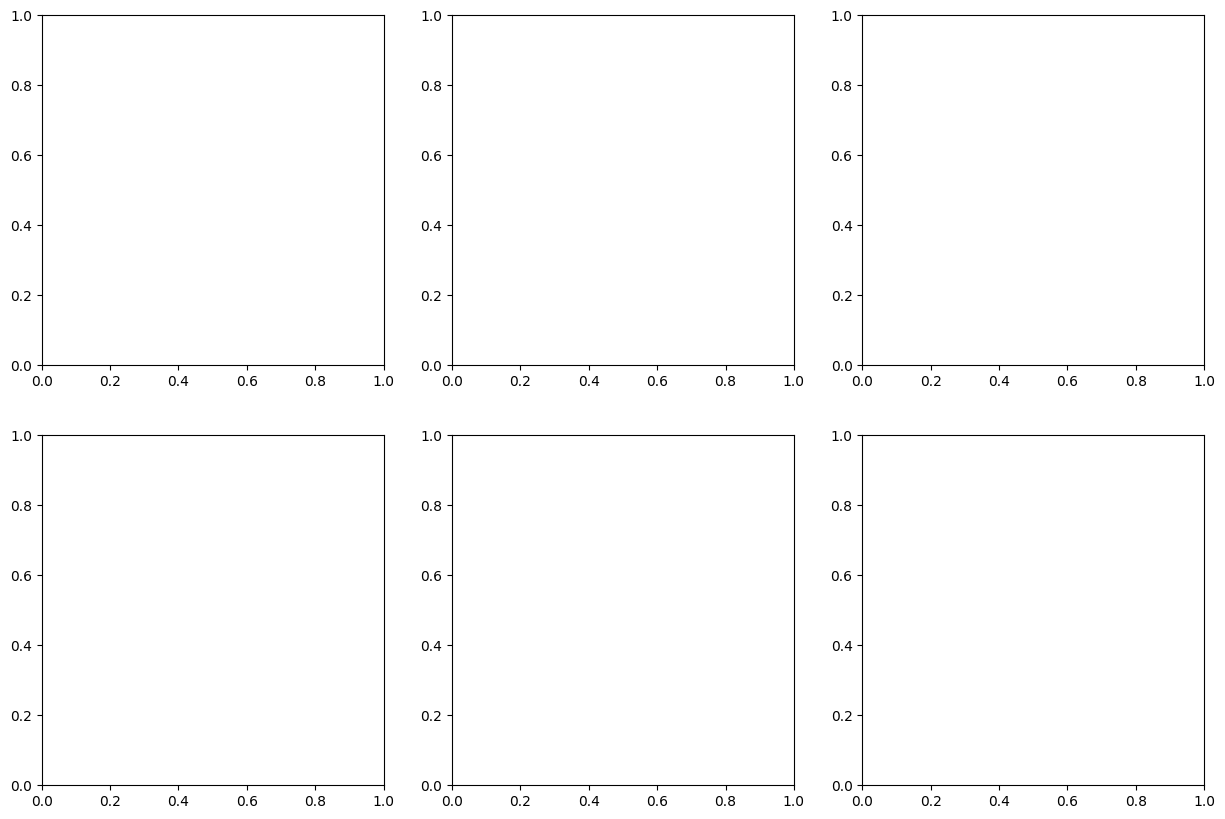

In [17]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))

for i, category in enumerate(categories, start=1):
    data = facilities_list[f'DISCHARGES_TO_{category.upper()}_IMPAIRED_BODY'].value_counts()
    ax = locals()[f'ax{i}']
    data.plot(kind='pie', autopct='%1.1f%%', ax=ax)
    ax.set_title(f'Facilities Discharging to Any\n{category}-Impaired Water Bodies\n(Total: {len(facilities_list)})')

# Add labels with the number of facilities for each category
for ax, data in zip([ax1, ax2, ax3, ax4, ax5, ax6], [data1, data2, data3, data4, data5, data6]):
    labels = [f'{k}\n({v:,})' for k, v in data.items()]
    ax.legend(labels, loc='best', bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

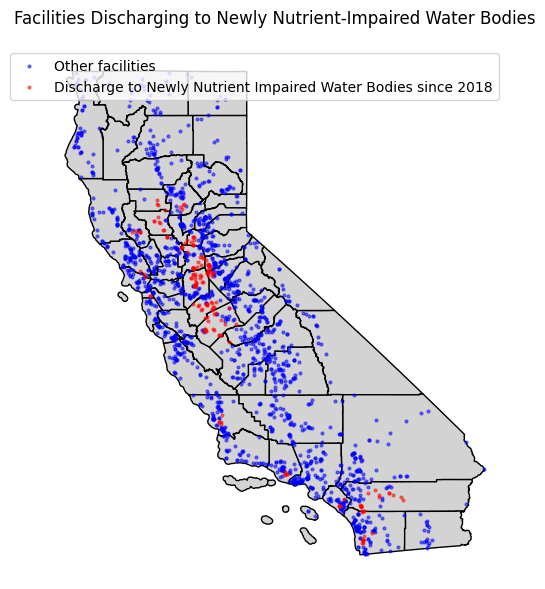

In [ ]:
# Create a GeoDataFrame from facilities_list
gdf = gpd.GeoDataFrame(
    facilities_list, 
    geometry=[Point(xy) for xy in zip(facilities_list['LONGITUDE.DECIMAL.DEGREES'],
                                      facilities_list['LATITUDE.DECIMAL.DEGREES'])],
    crs="EPSG:4326"
)

# load CA_Counties.shp 
california = gpd.read_file('ca_counties/CA_Counties.shp')

# If CRS don't match, reproject one to match the other
if gdf.crs != california.crs:
    if california.crs is None:
        california = california.set_crs(gdf.crs)
    else:
        gdf = gdf.to_crs(california.crs)

# Plot California county outlines and facilites as dots
fig, ax = plt.subplots(figsize=(6, 6))
california.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf[gdf['DISCHARGES_TO_NEWLY_NUTR_IMPAIRED_BODY'] == False].plot(ax=ax, color='blue', markersize=4, alpha=0.5, label='Other facilities')
gdf[gdf['DISCHARGES_TO_NEWLY_NUTR_IMPAIRED_BODY'] == True].plot(ax=ax, color='red', markersize=4, alpha=0.5, label='Discharge to Newly Nutrient Impaired Water Bodies since 2018')

# Customize the plot
ax.set_title('Facilities Discharging to Newly Nutrient-Impaired Water Bodies')
ax.legend()
ax.axis('off')

# plt.text(0.05, 0.05, f"GDF CRS: {gdf.crs}\nCalifornia CRS: {california.crs}", transform=ax.transAxes)
plt.tight_layout()
plt.show()

In [ ]:
facilities_list.columns

Index(['REGION', 'FACILITY.ID', 'LATITUDE.DECIMAL.DEGREES',
       'LONGITUDE.DECIMAL.DEGREES', 'FACILITY.NAME', 'PLACE.TYPE',
       'PLACE.SUBTYPE', 'FACILITY.TYPE', 'CAL.WATERSHED.NAME', 'NPDES...CA.',
       'DISCHARGES_TO_NEWLY_NUTR_IMPAIRED_BODY',
       'DISCHARGES_TO_NUTR_IMPAIRED_BODY', 'N_or_P_permit_limited'],
      dtype='object')

In [ ]:
# Import the REF_Parameter.csv file
ref_parameter = pd.read_csv('REF_Parameter.csv')

# Create a mapping of pollutant codes to categories
pollutant_category_map = dict(zip(ref_parameter['PARAMETER_CODE'], ref_parameter['CATEGORY']))

# Group limits_2023 by EXTERNAL_PERMIT_NMBR and aggregate PARAMETER_CODE
facility_pollutants = limits_2023.groupby('EXTERNAL_PERMIT_NMBR')['PARAMETER_CODE'].agg(lambda x: ','.join(set(x))).reset_index()

# Function to check if facility's pollutants match the impairment category
def matches_impairment_category(facility_pollutants, impairment_categories):
    facility_categories = set(pollutant_category_map.get(p, '') for p in facility_pollutants.split(',') if p)
    return bool(facility_categories.intersection(impairment_categories))

# Merge facility_pollutants with facilities_list
facilities_list = facilities_list.merge(facility_pollutants, left_on='NPDES...CA.', right_on='EXTERNAL_PERMIT_NMBR', how='left')

# Update the facilities_list DataFrame
facilities_list['MATCHES_IMPAIRMENT_CATEGORY'] = facilities_list.apply(
    lambda row: matches_impairment_category(
        row['PARAMETER_CODE'] if pd.notna(row['PARAMETER_CODE']) else '',
        set(pollutant_category_map.get(p, '') for p in str(row['Pollutant Category']).split(',') if p)
    ),
    axis=1
)

# Create pie charts
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Pie chart 1: All facilities
data1 = facilities_list['DISCHARGES_TO_NEWLY_NUTR_IMPAIRED_BODY'].value_counts()
ax1.pie(data1.values, labels=data1.index, autopct='%1.1f%%', startangle=90)
ax1.set_title(f'Facilities Discharging to Newly Impaired Waters\n(Total: {len(facilities_list)})')

# Pie chart 2: Facilities discharging to newly impaired waters
data2 = facilities_list[facilities_list['DISCHARGES_TO_NEWLY_NUTR_IMPAIRED_BODY']]['MATCHES_IMPAIRMENT_CATEGORY'].value_counts()
ax2.pie(data2.values, labels=data2.index, autopct='%1.1f%%', startangle=90)
ax2.set_title(f'Facilities Discharging to Newly Impaired Waters\nMatching Impairment Category\n(Total: {data2.sum()})')

# Pie chart 3: Facilities discharging to newly impaired waters and not matching impairment category
data3 = facilities_list[(facilities_list['DISCHARGES_TO_NEWLY_NUTR_IMPAIRED_BODY']) & (~facilities_list['MATCHES_IMPAIRMENT_CATEGORY'])]['N_or_P_permit_limited'].value_counts()
ax3.pie(data3.values, labels=data3.index, autopct='%1.1f%%', startangle=90)
ax3.set_title(f'Facilities Discharging to Newly Impaired Waters\nNOT Matching Impairment Category\n(Total: {data3.sum()})')

# Add labels with the number of facilities for each category
for ax, data in zip([ax1, ax2, ax3], [data1, data2, data3]):
    labels = [f'{k}\n({v:,})' for k, v in data.items()]
    ax.legend(labels, loc='best', bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

# Create a GeoDataFrame from facilities_list
gdf = gpd.GeoDataFrame(
    facilities_list, 
    geometry=[Point(xy) for xy in zip(facilities_list['LONGITUDE.DECIMAL.DEGREES'],
                                      facilities_list['LATITUDE.DECIMAL.DEGREES'])],
    crs="EPSG:4326"
)

# Load CA_Counties.shp 
california = gpd.read_file('ca_counties/CA_Counties.shp')

# If CRS don't match, reproject one to match the other
if gdf.crs != california.crs:
    if california.crs is None:
        california = california.set_crs(gdf.crs)
    else:
        gdf = gdf.to_crs(california.crs)

# Plot California county outlines and facilities as dots
fig, ax = plt.subplots(figsize=(8, 8))
california.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot facilities not discharging to newly impaired waters
gdf[~gdf['DISCHARGES_TO_NEWLY_NUTR_IMPAIRED_BODY']].plot(ax=ax, color='blue', markersize=4, alpha=0.5, label='Other facilities')

# Plot facilities discharging to newly impaired waters but not matching impairment category
gdf[(gdf['DISCHARGES_TO_NEWLY_NUTR_IMPAIRED_BODY']) & (~gdf['MATCHES_IMPAIRMENT_CATEGORY'])].plot(ax=ax, color='orange', markersize=4, alpha=0.5, label='Discharge to Newly Impaired Waters (Not Matching Category)')

# Plot facilities discharging to newly impaired waters and matching impairment category
gdf[(gdf['DISCHARGES_TO_NEWLY_NUTR_IMPAIRED_BODY']) & (gdf['MATCHES_IMPAIRMENT_CATEGORY'])].plot(ax=ax, color='red', markersize=4, alpha=0.5, label='Discharge to Newly Impaired Waters (Matching Category)')

# Customize the plot
ax.set_title('Facilities Discharging to Newly Impaired Water Bodies')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.axis('off')

plt.tight_layout()
plt.show()


KeyError: 'Pollutant Category'